In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# google drive 경로
prefix = '/content/drive/MyDrive/데이터크리에이터캠프/CV/task1/jinwoo'

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [7]:
# tup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU 출력
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # TPU 분산 전략 출력. 없으면 CPU
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.76.92.42:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.76.92.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.76.92.42:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [8]:
# mnist fasion 데이터 로드
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [9]:
# valid 데이터 셋 생성
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, stratify=train_labels)

In [10]:
# 데이터 셋 shape
train_images.shape, val_images.shape, test_images.shape

((45000, 28, 28), (15000, 28, 28), (10000, 28, 28))

In [11]:
# class 의 수
num_class = len(np.unique(test_labels))

In [12]:
# y를 one-hot 인코딩
train_labels = keras.utils.to_categorical(train_labels)
val_labels = keras.utils.to_categorical(val_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [13]:
# 전처리 함수
# X 를 정규화
def preprocess(x, y):
  x = tf.cast(x, dtype=tf.float32)
  x = x/255.0
  x = tf.expand_dims(x, 3)
  return x, y

# resize X
# Input size 는 최소 32x32이어야 한다.
def resizing(x, y):
  x = tf.image.resize(x, (32, 32))
  return x, y

In [14]:
# train, valid, test 데이터 셋 생성
# valid, test는 셔플 x
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(preprocess).map(resizing).shuffle(1000, seed=42)    # shuffle

val_dataset  = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(preprocess).map(resizing)

test_dataset  = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.map(preprocess).map(resizing)

In [15]:
next(iter(train_dataset))[0].shape

TensorShape([64, 32, 32, 1])

In [21]:
with strategy.scope():
    # VGG16 로드. 무작위 weight 초기화, top layer 제거
    base = keras.applications.VGG16(input_shape=(32, 32, 1), weights=None, include_top=False)

    # top layer 생성
    model = keras.models.Sequential()
    model.add(base)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(num_class, activation='softmax'))

    model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics='accuracy'
    )

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14713536  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 14,718,666
Trainable params: 14,718,666
Non-trainable params: 0
_________________________________________________________________


In [23]:
# callback 함수

# checkpoint 경로
ckpt_name = 'VGG16_ckpt.hdf5'
checkpoint_dir_path = os.path.join(prefix, 'checkpoint')
checkpoint_path = os.path.join(prefix, 'checkpoint', ckpt_name)

# checkpoint 경로 확인
# 경로가 존재하지 않으면 생성
if not(os.path.exists(checkpoint_dir_path)):
  os.mkdir(checkpoint_dir_path)

callbacks_list = [
    # 매 epoch마다 val_loss 기준 가장 작은 상태의 weight 저장
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True
    ),
    # val_loss 가 5번 동안 향상되지 않으면 훈련 종료
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1, 
        patience=5
    )
]

In [24]:
hist = model.fit(train_dataset, validation_data=val_dataset, callbacks=callbacks_list, epochs=20)

Epoch 1/20
704/704 [==============================] - 43s 40ms/step - loss: 0.7661 - accuracy: 0.7087 - val_loss: 0.4150 - val_accuracy: 0.8527
Epoch 2/20
704/704 [==============================] - 16s 23ms/step - loss: 0.3869 - accuracy: 0.8561 - val_loss: 0.3460 - val_accuracy: 0.8680
Epoch 3/20
704/704 [==============================] - 16s 23ms/step - loss: 0.3178 - accuracy: 0.8837 - val_loss: 0.3147 - val_accuracy: 0.8870
Epoch 4/20
704/704 [==============================] - 16s 23ms/step - loss: 0.2927 - accuracy: 0.8935 - val_loss: 0.2829 - val_accuracy: 0.8959
Epoch 5/20
704/704 [==============================] - 16s 23ms/step - loss: 0.2608 - accuracy: 0.9048 - val_loss: 0.2774 - val_accuracy: 0.9012
Epoch 6/20
704/704 [==============================] - 16s 23ms/step - loss: 0.2440 - accuracy: 0.9113 - val_loss: 0.2824 - val_accuracy: 0.8993
Epoch 7/20
704/704 [==============================] - 16s 22ms/step - loss: 0.2299 - accuracy: 0.9163 - val_loss: 0.2362 - val_accuracy:

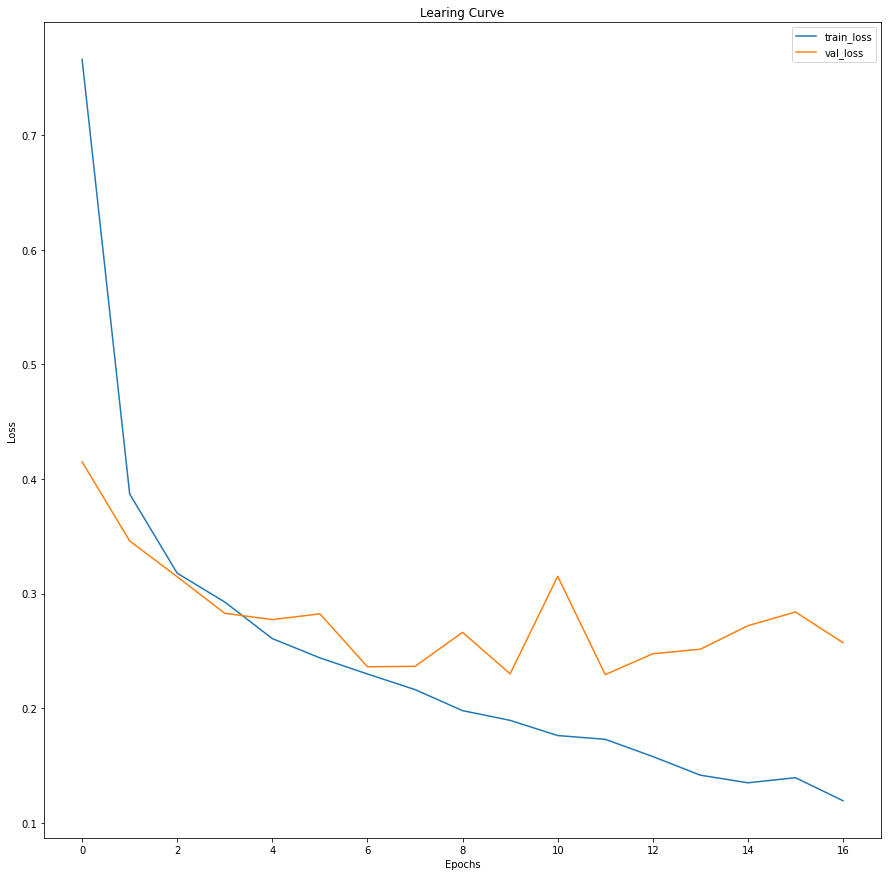

In [25]:
# learning curve
plt.figure(figsize=(15, 15))
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Learing Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [26]:
# 마지막 checkpoint weight 로드
model.load_weights(checkpoint_path)

In [27]:
# test 셋 평가
model.evaluate(test_dataset)

157/157 [==============================] - 4s 20ms/step - loss: 0.2629 - accuracy: 0.9149


[0.262851744890213, 0.914900004863739]